In [ ]:
from google.colab import files
uploaded = files.upload()


Saving ID_00042829c.npy to ID_00042829c.npy


In [ ]:
%pip install qiskit==0.46.0 qiskit-aer==0.13.0 qiskit-algorithms==0.2.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 53.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.9/306.9 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 84.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the

Original image shape: (512, 512, 3)


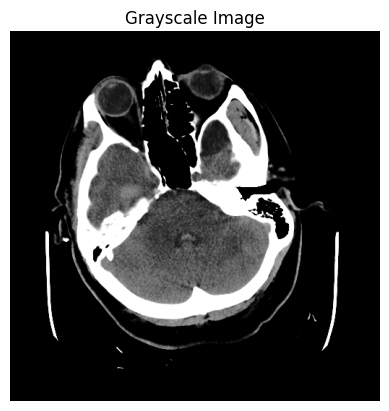

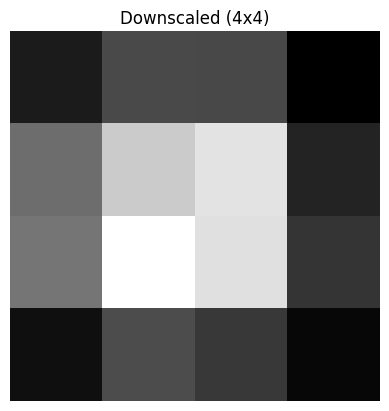

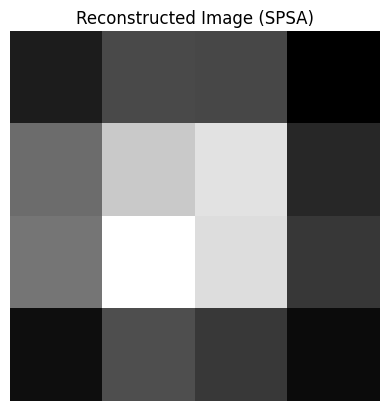

In [ ]:


# Imports
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray
from qiskit.algorithms.optimizers import SPSA

# Load and preview image
image = np.load('/content/ID_00042829c.npy')
print(f"Original image shape: {image.shape}")  # Should be (H, W, 3)

# Convert to grayscale if RGB
if image.ndim == 3 and image.shape[2] == 3:
    image_gray = rgb2gray(image)
else:
    image_gray = image

# Show grayscale image
plt.imshow(image_gray, cmap='gray')
plt.title('Grayscale Image')
plt.axis('off')
plt.show()

# Downscale to 4x4
resized_shape = (4, 4)
small_image = resize(image_gray, resized_shape, anti_aliasing=True)

# Confirm new shape
assert small_image.shape == resized_shape, f"Unexpected shape: {small_image.shape}"

# Show resized image
plt.imshow(small_image, cmap='gray')
plt.title('Downscaled (4x4)')
plt.axis('off')
plt.show()

# Flatten to 1D vector
target = small_image.flatten()

# Define loss function (mean squared error)
def loss(params):
    return np.mean((params - target) ** 2)

# Use SPSA optimizer
optimizer = SPSA(maxiter=300)
initial_point = np.random.rand(len(target))  # Should be 16 values

# Run optimization
result = optimizer.minimize(fun=loss, x0=initial_point)

# Reshape and clip result
optimized_image = np.clip(result.x, 0, 1).reshape(resized_shape)

# Show reconstructed image
plt.imshow(optimized_image, cmap='gray')
plt.title('Reconstructed Image (SPSA)')
plt.axis('off')
plt.show()


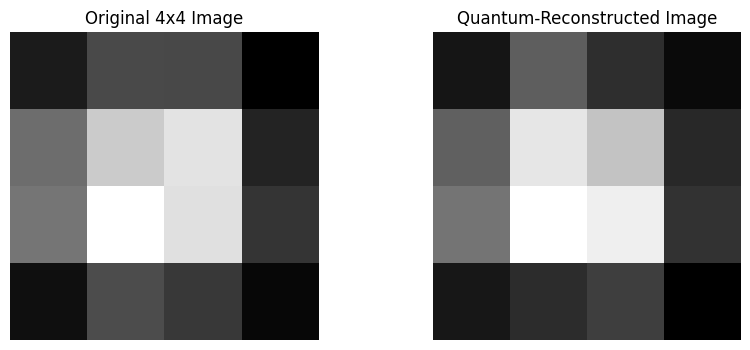

In [ ]:


import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray

from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.algorithms.optimizers import SPSA

#  Load and preprocess image
img = np.load('/content/ID_00042829c.npy')
if img.ndim == 3 and img.shape[2] == 3:
    img = rgb2gray(img)
small = resize(img, (4, 4), anti_aliasing=True)
target = small.flatten()
norm = np.linalg.norm(target)
target = target / norm

# Prepare target quantum state (amplitude encoded)
num_qubits = int(np.log2(len(target)))
init_circuit = QuantumCircuit(num_qubits)
init_circuit.initialize(target, range(num_qubits))
target_state = Statevector.from_instruction(init_circuit)

# Defined variational circuit (ansatz)
reps = 2
ansatz = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=reps, insert_barriers=True)

# Objective function: Fidelity loss
def objective(params):
    trial_circuit = QuantumCircuit(num_qubits)
    trial_circuit.compose(ansatz.assign_parameters(params), inplace=True)
    trial_state = Statevector.from_instruction(trial_circuit)
    fidelity = state_fidelity(trial_state, target_state)
    return 1 - fidelity  # Loss: lower is better
# run SPSA optimization
init_point = np.random.rand(ansatz.num_parameters)
optimizer = SPSA(maxiter=200)
result = optimizer.minimize(fun=objective, x0=init_point)

#Reconstruct state and convert back to image
final_circuit = QuantumCircuit(num_qubits)
final_circuit.compose(ansatz.assign_parameters(result.x), inplace=True)
final_state = Statevector.from_instruction(final_circuit)
reconstructed = np.real(final_state.data) * norm
reconstructed = np.clip(reconstructed, 0, 1).reshape((4, 4))

# pot results
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.imshow(small, cmap='gray')
plt.title('Original 4x4 Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title('Quantum-Reconstructed Image')
plt.axis('off')
plt.show()


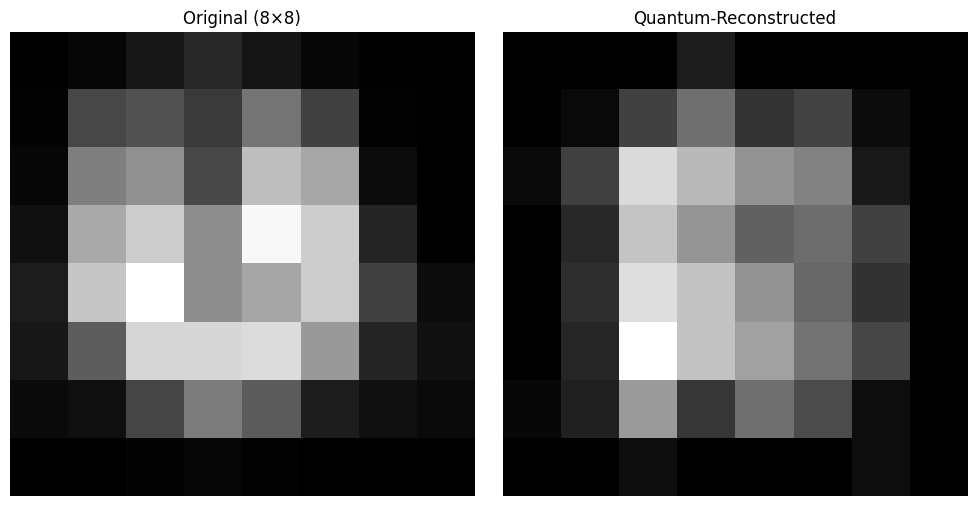

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.color import rgb2gray

from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.algorithms.optimizers import SPSA

image = np.load('/content/ID_00042829c.npy')
if image.ndim == 3:
    image = rgb2gray(image)
small = resize(image, (8, 8), anti_aliasing=True)
target = small.flatten()
norm = np.linalg.norm(target)
target = target / norm

num_qubits = int(np.log2(len(target)))  # Should be 6 qubits
init_circuit = QuantumCircuit(num_qubits)
init_circuit.initialize(target, range(num_qubits))
target_state = Statevector.from_instruction(init_circuit)

ansatz = TwoLocal(num_qubits, rotation_blocks=['ry', 'rz'], entanglement_blocks='cz', reps=2)

def objective(params):
    trial_circ = QuantumCircuit(num_qubits)
    trial_circ.compose(ansatz.assign_parameters(params), inplace=True)
    trial_state = Statevector.from_instruction(trial_circ)
    fidelity = state_fidelity(trial_state, target_state)
    return 1 - fidelity  # we minimize 1 - fidelity

init_point = np.random.rand(ansatz.num_parameters)
optimizer = SPSA(maxiter=300)
result = optimizer.minimize(fun=objective, x0=init_point)

final_circ = QuantumCircuit(num_qubits)
final_circ.compose(ansatz.assign_parameters(result.x), inplace=True)
final_state = Statevector.from_instruction(final_circ)
reconstructed = np.real(final_state.data) * norm
reconstructed = np.clip(reconstructed, 0, 1).reshape((8, 8))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(small, cmap='gray')
plt.title("Original (8×8)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed, cmap='gray')
plt.title("Quantum-Reconstructed")
plt.axis('off')

plt.tight_layout()
plt.show()


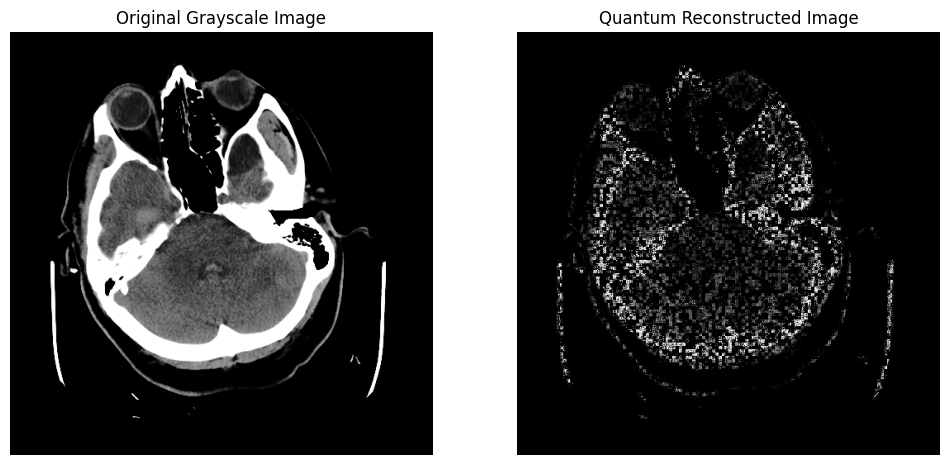

In [ ]:

import numpy as np
import matplotlib.pyplot as plt
from skimage.util import view_as_blocks
from skimage.color import rgb2gray
from qiskit import QuantumCircuit
from qiskit.circuit.library import TwoLocal
from qiskit.quantum_info import Statevector, state_fidelity
from qiskit.algorithms.optimizers import SPSA

# Load image
image = np.load('/content/ID_00042829c.npy')  # shape (512,512,3)

# Parameters
patch_size = 4
h, w, c = image.shape
assert c == 3

# Pad image so divisible by patch_size
h_pad = patch_size - h % patch_size if h % patch_size != 0 else 0
w_pad = patch_size - w % patch_size if w % patch_size != 0 else 0
image_padded = np.pad(image, ((0,h_pad),(0,w_pad),(0,0)), mode='constant')

# Split into patches
patches = view_as_blocks(image_padded, block_shape=(patch_size, patch_size, 3))
patches = patches.reshape(-1, patch_size, patch_size, 3)

reconstructed_patches = []

def reconstruct_patch_rgb(patch):
    # Convert patch to grayscale to reduce complexity
    patch_gray = rgb2gray(patch)
    patch_flat = patch_gray.flatten()
    norm = np.linalg.norm(patch_flat)
    if norm == 0:
        return patch_gray  # avoid division by zero
    target = patch_flat / norm

    num_qubits = int(np.log2(len(target)))
    if 2**num_qubits != len(target):
        # Resize patch_gray to nearest power of 2 length (e.g. 16 for 4x4)
        from skimage.transform import resize
        side = int(np.sqrt(2**num_qubits))
        patch_gray = resize(patch_gray, (side, side), anti_aliasing=True)
        patch_flat = patch_gray.flatten()
        norm = np.linalg.norm(patch_flat)
        target = patch_flat / norm
        num_qubits = int(np.log2(len(target)))

    # Initialize target quantum state
    init_circuit = QuantumCircuit(num_qubits)
    init_circuit.initialize(target, range(num_qubits))
    target_state = Statevector.from_instruction(init_circuit)

    # Variational circuit
    ansatz = TwoLocal(num_qubits, ['ry', 'rz'], 'cz', reps=2)

    # Objective function (1 - fidelity)
    def objective(params):
        trial_circ = QuantumCircuit(num_qubits)
        trial_circ.compose(ansatz.assign_parameters(params), inplace=True)
        trial_state = Statevector.from_instruction(trial_circ)
        fidelity = state_fidelity(trial_state, target_state)
        return 1 - fidelity

    # SPSA optimization
    init_point = np.random.rand(ansatz.num_parameters)
    optimizer = SPSA(maxiter=50)  # 50 iterations for speed; increase for accuracy
    result = optimizer.minimize(fun=objective, x0=init_point)

    # Reconstructed state vector
    final_circ = QuantumCircuit(num_qubits)
    final_circ.compose(ansatz.assign_parameters(result.x), inplace=True)
    final_state = Statevector.from_instruction(final_circ)
    reconstructed = np.real(final_state.data) * norm
    reconstructed = np.clip(reconstructed, 0, 1)

    # Reshape back to patch size
    side = int(np.sqrt(len(reconstructed)))
    reconstructed_patch = reconstructed.reshape((side, side))
    return reconstructed_patch

# Reconstruct all patches
for i, patch in enumerate(patches):
    print(f"Processing patch {i+1}/{len(patches)}...", end='\r')
    rec_patch = reconstruct_patch_rgb(patch)
    reconstructed_patches.append(rec_patch)

# Stitch patches back into full grayscale image
side = int(np.sqrt(len(reconstructed_patches[0].flatten())))
patches_per_row = (w + w_pad) // patch_size
rows = (h + h_pad) // patch_size

reconstructed_patches = np.array(reconstructed_patches)
reconstructed_image = reconstructed_patches.reshape(rows, patches_per_row, side, side)
reconstructed_image = reconstructed_image.swapaxes(1,2).reshape(rows*side, patches_per_row*side)

# Crop to original size
reconstructed_image = reconstructed_image[:h, :w]

# Plot original grayscale and reconstructed grayscale
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(rgb2gray(image), cmap='gray')
plt.title('Original Grayscale Image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(reconstructed_image, cmap='gray')
plt.title('Quantum Reconstructed Image')
plt.axis('off')

plt.show()
